# TTI elastic with a sinusoid boundary

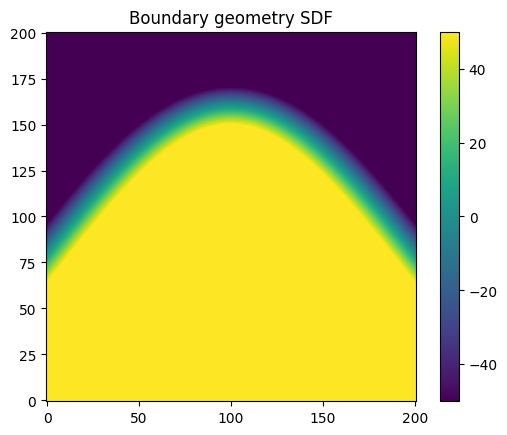

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = '../tests/sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the sinusoid 2D sdf
sdf = read_sdf('sinusoid_new_hi_res', 2)

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

In [2]:
from schism import BoundaryGeometry
import sympy as sp

zero = sp.core.numbers.Zero()
cutoff = {(zero, zero): 0.}

bg = BoundaryGeometry(sdf)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


In [3]:
import devito as dv

s_o = 4

ux = dv.TimeFunction(name='ux', grid=grid, space_order=s_o, time_order=2)
uy = dv.TimeFunction(name='uy', grid=grid, space_order=s_o, time_order=2)

# Material parameters
v_p0 = 1.
v_s0 = 0.5
de = 0.1
ep = 0.25
rho = 1.
b = 1/rho
th = np.radians(45)

# Seismic wavespeeds
v_p02 = v_p0**2
v_s02 = v_s0**2
v_pn2 = (1+2*de)*v_p0**2
v_px2 = (1+2*ep)*v_p0**2

# VTI stiffness tensor entries (uses conventions from 3D case)
c11 = rho*v_px2
c13 = rho*np.sqrt((v_p02-v_s02)*(v_pn2-v_s02))-rho*v_s02
c33 = rho*v_p02
c44 = rho*v_s02

# Assemble the VTI stiffness tensor (Voigt notation)
C = sp.Matrix([[c11, c13, 0],
               [c13, c33, 0],
               [0, 0, c44]])

In [4]:
# Stiffness tensor rotation

# Rotation matrix
R = sp.Matrix([[np.cos(th), -np.sin(th)],
               [np.sin(th), np.cos(th)]])

# Apparatus to perform rotation
voigt = {(0, 0): 0, (1, 1): 1, (0, 1): 2, (1, 0): 2}


def as_tensor(matrix):
    """Convert Voigt notation to stiffness tensor in 2D"""
    tensor = sp.tensor.array.MutableDenseNDimArray.zeros(2, 2, 2, 2)
    
    for k1, v1 in voigt.items():
        i, j = k1
        alpha = v1
        for k2, v2 in voigt.items():
            k, l = k2
            beta = v2
            tensor[i, j, k, l] = matrix[alpha, beta]
    return tensor


def tensor_to_matrix(tensor):
    """Convert stiffness tensor to Voigt notation in 2D"""
    matrix = sp.zeros(3, 3)
    
    for k1, v1 in voigt.items():
        i, j = k1
        alpha = v1
        for k2, v2 in voigt.items():
            k, l = k2
            beta = v2
            matrix[alpha, beta] = tensor[i, j, k, l]
    return matrix


def rotate(matrix, R):
    """Rotate a stiffness tensor in Voigt notation using matrix R"""
    C = as_tensor(matrix)
    rotated = sp.tensor.array.MutableDenseNDimArray.zeros(2, 2, 2, 2)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    for ii in range(2):
                        for jj in range(2):
                            for kk in range(2):
                                for ll in range(2):
                                    gg = R[ii, i]*R[jj, j]*R[kk, k]*R[ll, l]
                                    rotated[i, j, k, l] += gg*C[ii, jj, kk, ll]
                    rotated[i, j, k, l] = sp.collect(rotated[i, j, k, l],
                                                     [c11, c13, c44, c33])
    return tensor_to_matrix(rotated)


# Get the rotated stiffness tensor (D)
D = rotate(C, R)

# Shorthands for components of D
d11 = D[0, 0]
d12 = D[0, 1]
d13 = D[0, 2]
d22 = D[1, 1]
d23 = D[1, 2]
d33 = D[2, 2]

In [5]:
from schism import BoundaryConditions

nx = bg.n[0]
ny = bg.n[1]

# Note that a factor of rho has been removed here
txx = d11*ux.dx + d12*uy.dy + d13*ux.dy + d13*uy.dx
tyy = d12*ux.dx + d22*uy.dy + d23*ux.dy + d23*uy.dx
txy = d13*ux.dx + d23*uy.dy + d33*ux.dy + d33*uy.dx

# With fourth-order boundary conditions
bc_list = [dv.Eq(nx*txx + ny*txy, 0),
           dv.Eq(nx*txy + ny*tyy, 0),
           dv.Eq(ux.dx2dy*(3*d11*d13*nx + d11*d33*ny + d12**2*ny
                           + d12*d13*nx + d12*d33*ny + 2*d13**2*ny
                           + d13*d23*ny + 2*d13*d33*nx)
                 + ux.dx3*(d11**2*nx + d11*d13*ny + d12*d13*ny + d13**2*nx)
                 + ux.dxdy2*(d11*d33*nx + 2*d12*d23*ny + d12*d33*nx
                             + 2*d13**2*nx + d13*d23*nx + 3*d13*d33*ny
                             + d23*d33*ny + d33**2*nx)
                 + ux.dy3*(d13*d33*nx + d23**2*ny + d23*d33*nx + d33**2*ny)
                 + uy.dx2dy*(d11*d12*nx + d11*d23*ny + d12*d23*ny
                             + d12*d33*nx + 2*d13**2*nx + d13*d22*ny
                             + d13*d23*nx + 2*d13*d33*ny + d23*d33*ny
                             + d33**2*nx)
                 + uy.dx3*(d11*d13*nx + d11*d33*ny + d13*d23*ny + d13*d33*nx)
                 + uy.dxdy2*(2*d12*d13*nx + d12*d22*ny + d12*d23*nx
                             + 2*d13*d23*ny + d13*d33*nx + d22*d33*ny
                             + d23**2*ny + 2*d23*d33*nx + d33**2*ny)
                 + uy.dy3*(d12*d33*nx + d22*d23*ny + d23**2*nx + d23*d33*ny), 0),
           dv.Eq(ux.dx2dy*(d11*d12*nx + d11*d33*nx + d12*d13*ny + 2*d12*d23*ny
                           + d13**2*nx + 2*d13*d23*nx + 2*d13*d33*ny
                           + d23*d33*ny + d33**2*nx)
                 + ux.dx3*(d11*d13*nx + d12*d33*ny + d13**2*ny + d13*d33*nx)
                 + ux.dxdy2*(d11*d23*nx + d12*d13*nx + d12*d22*ny + d12*d33*ny
                             + d13*d22*nx + d13*d23*ny + d13*d33*nx
                             + 2*d23**2*ny + 2*d23*d33*nx + d33**2*ny)
                 + ux.dy3*(d13*d23*nx + d22*d23*ny + d22*d33*nx + d23*d33*ny)
                 + uy.dx2dy*(2*d12*d13*nx + d12*d33*ny + d13*d23*ny
                            + d13*d33*nx + d22*d33*ny + 2*d23**2*ny
                            + 3*d23*d33*nx + d33**2*ny)
                 + uy.dx3*(d13**2*nx + d13*d33*ny + d23*d33*ny + d33**2*nx)
                 + uy.dxdy2*(d12**2*nx + d12*d23*ny + d12*d33*nx + d13*d23*nx
                             + 3*d22*d23*ny + d22*d33*nx + 2*d23**2*nx
                             + 2*d23*d33*ny)
                 + uy.dy3*(d12*d23*nx + d22**2*ny + d22*d23*nx + d23**2*ny), 0)]
# bc_list = [dv.Eq(nx*txx + ny*txy, 0),
#            dv.Eq(nx*txy + ny*tyy, 0)]

bcs = BoundaryConditions(bc_list)

In [6]:
from schism import Boundary

boundary = Boundary(bcs, bg)

derivs = (ux.dx2, ux.dy2, ux.dxdy, uy.dx2, uy.dy2, uy.dxdy)

subs = boundary.substitutions(derivs)

Generating stencils for Derivative(ux(t, x, y), (x, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(ux(t, x, y), (y, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(ux(t, x, y), x, y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), (x, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), (y, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), x, y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


In [15]:
from examples.seismic import TimeAxis, RickerSource

# Reset the fields
ux.data[:] = 0
uy.data[:] = 0

t0 = 0.  # Simulation starts a t=0
tn = 650.  # Simulation last 0.65 seconds (650 ms)
dt = 0.5*grid.spacing[0]/v_p0  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.008  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 600.

In [16]:
rhs_ux = b*(d11*ux.dx2 + 2*d13*ux.dxdy + d33*ux.dy2
            + d13*uy.dx2 + (d12+d33)*uy.dxdy + d23*uy.dy2)
rhs_uy = b*(d13*ux.dx2 + (d12+d33)*ux.dxdy + d23*ux.dy2
            + d33*uy.dx2 + 2*d23*uy.dxdy + d22*uy.dy2)

eq_ux = dv.Eq(ux.forward,
              2*ux - ux.backward
              + dt**2*rhs_ux.subs(subs))

eq_uy = dv.Eq(uy.forward,
              2*uy - uy.backward
              + dt**2*rhs_uy.subs(subs))

In [17]:
src_ux = src.inject(field=ux.forward, expr=src*dt**2)

In [18]:
op = dv.Operator([eq_ux, eq_uy] + src_ux)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 5.07 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=5.063723, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0002829999999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

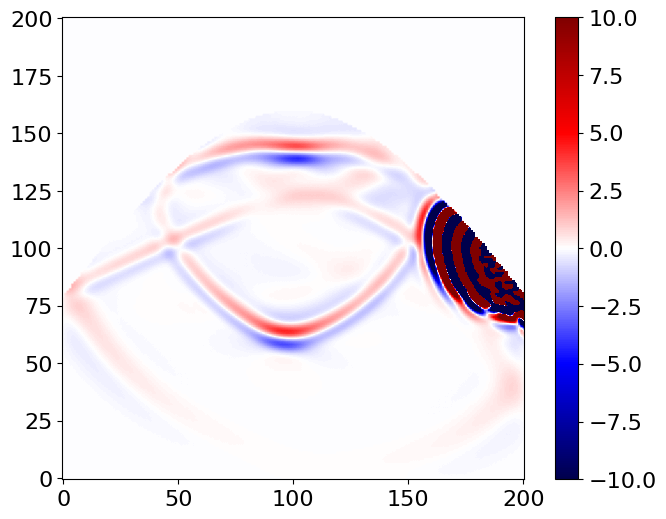

In [19]:
# plt.imshow(ux.data[1].T, origin='lower', cmap='seismic',
#            vmax=np.amax(np.abs(ux.data[1])), vmin=-np.amax(np.abs(ux.data[1])))
plt.imshow(ux.data[1].T, origin='lower', cmap='seismic',
           vmax=10, vmin=-10)
plt.colorbar()
plt.show()

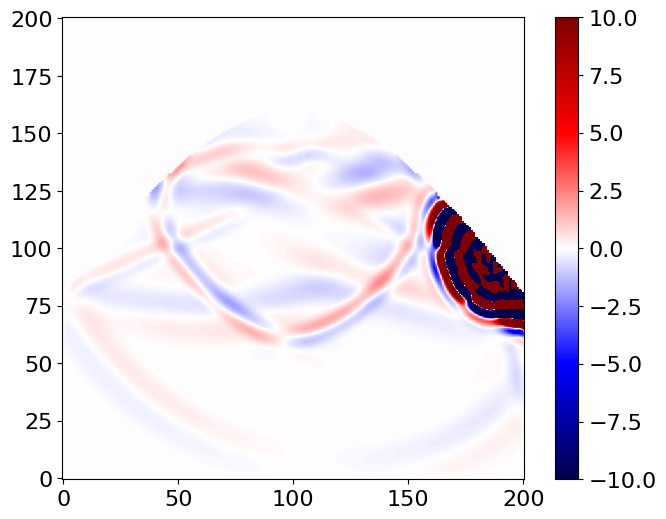

In [20]:
# plt.imshow(uy.data[1].T, origin='lower', cmap='seismic',
#            vmax=np.amax(np.abs(uy.data[1])), vmin=-np.amax(np.abs(uy.data[1])))
plt.imshow(uy.data[1].T, origin='lower', cmap='seismic',
           vmax=10, vmin=-10)
plt.colorbar()
plt.show()

In [21]:
np.amax(ux.data)

Data(67602856., dtype=float32)